# Import necessary libraries

In [ ]:
import pandas as pd
import math
import numpy as np
from fbprophet import Prophet
from fbprophet.plot import plot_cross_validation_metric 
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
import matplotlib.pyplot as plt

# Necessary Functions

In [ ]:
# Mean Absolute Error
def mean_absolute_error(y_true, y_pred): 
  return np.round(np.mean(np.abs((y_pred - y_true))),decimals=2)
# Mean Sqaured Error
def mean_squared_error( y_pred,y_true): 
  return np.round(np.mean((y_pred - y_true)**2),decimals=2)
# Root Mean Sqaured Error
def root_mean_squared_error(y_pred,y_true): 
  return np.round(np.sqrt(mean_squared_error(y_pred, y_true)),decimals=2)
# Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.round(np.mean(np.abs((y_pred - y_true) /np.abs(y_true))) * 100,decimals=2)

# Read the data

Read the input hospital data and then set the index to the 'Date' column.

In [ ]:
# Read the data
Hospital_df = pd.read_csv('ProcessedDataset.csv',parse_dates=True)
# Change the date format
Hospital_df['Date'] = pd.to_datetime(Hospital_df['Date'], format='%d-%m-%Y')
Hospital_df.index = Hospital_df['Date']

# Holidays Data 




*   Pull the hospital data from the input file
*   Aggregate the 3 German States Holiday columns for both School and Public Holidays
* Concatenate both the holidays into holidays dataframe under 'holiday' column name as Prophet model expects a single column holiday.

In [ ]:
#School holidays Aggregation
holidays_S = pd.DataFrame({'ds': Hospital_df["Date"],'holiday': Hospital_df[["S_BW", "S_H","S_RP"]].max(axis=1)})
holidays_S['holiday'] = holidays_S['holiday'].replace({1: 'schoolholiday', 0: 'noholidays'})
holidays_S = holidays_S[holidays_S['holiday'] == 'schoolholiday'] 
#Public holidays Aggregation
holidays_P = pd.DataFrame({'ds': Hospital_df["Date"],'holiday': Hospital_df[["P_BW", "P_H","P_RP"]].max(axis=1)})
holidays_P['holiday'] = holidays_P['holiday'].replace({1: 'publicholiday', 0: 'noholidays'})
holidays_P = holidays_P[holidays_P['holiday'] == 'publicholiday'] 
# Concatenating both holidays
holidays = pd.concat((holidays_S, holidays_P))
# Total Holidays
holidays.shape

(1584, 2)

# Train Test Split

In [ ]:
# Splitting the data into train and test dataframes
Train_df = Hospital_df.loc['2008-01-01':'2012-12-31']
Test_df = Hospital_df.loc['2013-01-01':'2013-01-30']
period = len(Test_df.index)
# Print the shape of test and train data
print(len(Test_df.index))
print(len(Train_df.index))

30
1827


# Prophet Model Preparation

For prophet to work,the model expects the names of these columns to 'ds'(Date) and 'y'(Occupancy) for training and test data

In [ ]:
# Discharges
Train_df_D=Train_df.rename(columns={'Date':'ds', 'Discharges':'y'})
Test_df_D=Test_df.rename(columns={'Date':'ds', 'Discharges':'y'})
Train_df_D = Train_df_D[['ds','y']]
Test_df_D = Test_df_D[['ds','y']]
# Admissions
Train_df_A=Train_df.rename(columns={'Date':'ds', 'Admissions':'y'})
Test_df_A=Test_df.rename(columns={'Date':'ds', 'Admissions':'y'})
Train_df_A = Train_df_A[['ds','y']]
Test_df_A = Test_df_A[['ds','y']]

# Discharges

## Plot

#### Plotting the Train data

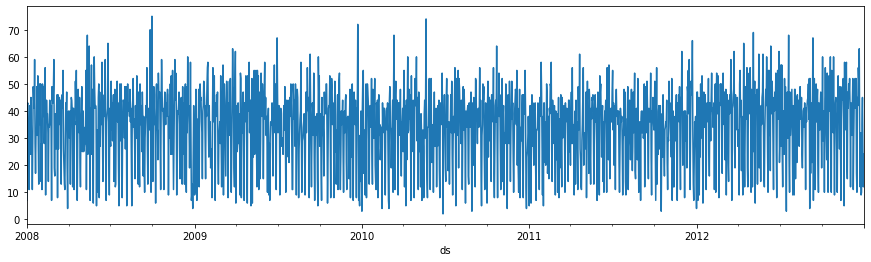

In [ ]:
Train_df_D.set_index('ds').y.plot(figsize=(15,4))

#### Plotting the Whole data

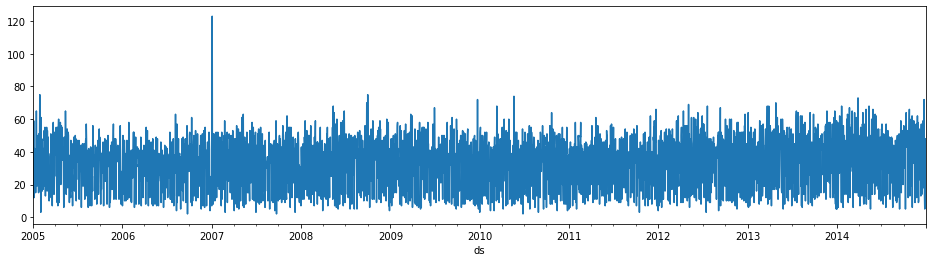

In [ ]:
Full_data = Hospital_df.loc['2005-01-01':'2014-12-31']
# Full_data = Full_data.reset_index()
Full_data_D=Full_data.rename(columns={'Date':'ds', 'Discharges':'y'})
Full_data_D.set_index('ds').y.plot(figsize=(16,4))

## Stationary Checks and code to make the data stationary

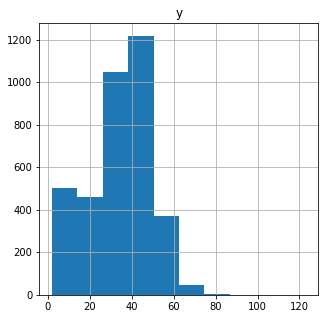

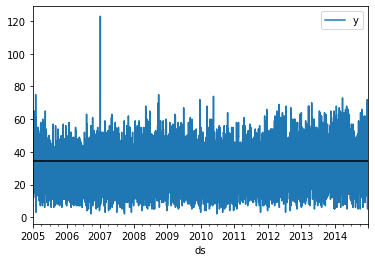

In [ ]:
#To check if the data is stationary
Full_data_D = Full_data_D[['ds','y']]
#Plotting the histogram for check for normal distribution
Full_data_D.hist(figsize=(5,5))
#Adding the horizontal line across the 'y' 
Full_data_D.set_index('ds', inplace=True)
Full_data_D.plot()
plt.axhline(Full_data_D['y'].mean(),c='black')
plt.show()

In [ ]:
# #Making the data Stationary
# Full_data_D['y'] = Full_data_D['y'] - Full_data_D['y'].shift(1)
# Full_data_D.plot()
# plt.axhline(Full_data_D['y'].mean(),c='black')
# plt.show()

## Running Prophet Model for Discharges


In [ ]:
# Passing the holidays dataframe having both school and public holidays as the parameters 
model_D = Prophet(holidays=holidays)
model_D.fit(Train_df_D);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#Holiday names
model_D.train_holiday_names

0    schoolholiday
1    publicholiday
dtype: object

## Forecasting Discharges:

Make a new dataframe containing the dates to be predicted for the future


periods --> number of days into the future

include_history --> True or False to include the training data

freq --> days,hours, months 


In [ ]:
#test
future = model_D.make_future_dataframe(periods=period,include_history = False,freq='D') 
#train
future_t = model_D.make_future_dataframe(periods=0,include_history = True,freq='D') 

To forecast this future data, we need to run it through Prophet's model.

In [ ]:
forecast_D = model_D.predict(future)
forecast_Dt = model_D.predict(future_t)
print(len(forecast_D.index))

30


Fields needed in the Forecast data :

yhat - Prediction output

yhat_lower and yhat_upper - confidence intervals for the prediction output

In [ ]:
forecast_D[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
25,2013-01-26,33.142355,18.531476,47.534193
26,2013-01-27,23.316885,6.652922,38.360840
27,2013-01-28,41.003274,27.040042,56.599064
28,2013-01-29,42.504529,27.910992,57.256450
29,2013-01-30,42.134849,27.400497,58.237251


## Error Metrics Discharges:


### Actual vs Predicted Plot

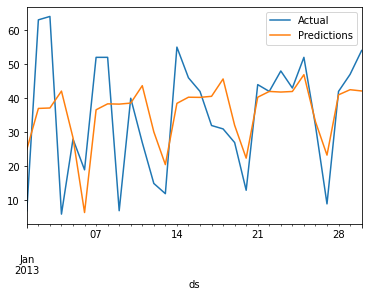

In [ ]:
# A vs P plot
test = Test_df_D.plot(x='ds',y='y',label='Actual',legend=True)
forecast_D.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(6,4),ax=test)

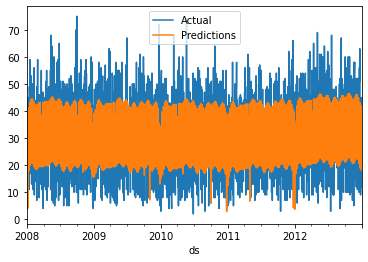

In [ ]:
# A vs P plot on the train data
train = Train_df_D.plot(x='ds',y='y',label='Actual',legend=True)
forecast_Dt.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(6,4),ax=train)

## Error Metrics
Calculation of MAPE, MAE and RMSE - Test

In [ ]:
print('Mean absolute percentage error: ',mean_absolute_percentage_error(Test_df_D['y'].values,forecast_D['yhat'].values))
print('Mean absolute error: ',mean_absolute_error(Test_df_D['y'].values,forecast_D['yhat'].values))
print('Root Mean Square error: ',root_mean_squared_error(forecast_D['yhat'].values,Test_df_D['y'].values))

Mean absolute percentage error:  73.05
Mean absolute error:  11.08
Root Mean Square error:  14.52


Calculation of MAPE, MAE and RMSE - Train

In [ ]:
print('Mean absolute percentage error: ',mean_absolute_percentage_error(Train_df_D['y'].values,forecast_Dt['yhat'].values))
print('Mean absolute error: ',mean_absolute_error(Train_df_D['y'].values,forecast_Dt['yhat'].values))
print('Root Mean Square error: ',root_mean_squared_error(forecast_Dt['yhat'].values,Train_df_D['y'].values))

Mean absolute percentage error:  46.15
Mean absolute error:  8.85
Root Mean Square error:  11.66


## Plotting Prophet results and the compoenents

Prophet has a plotting mechanism called ```plot```.  This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

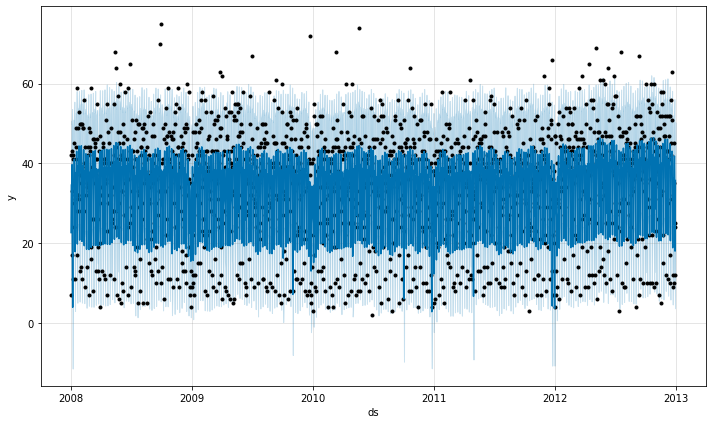

In [ ]:
model_D.plot(forecast_Dt);

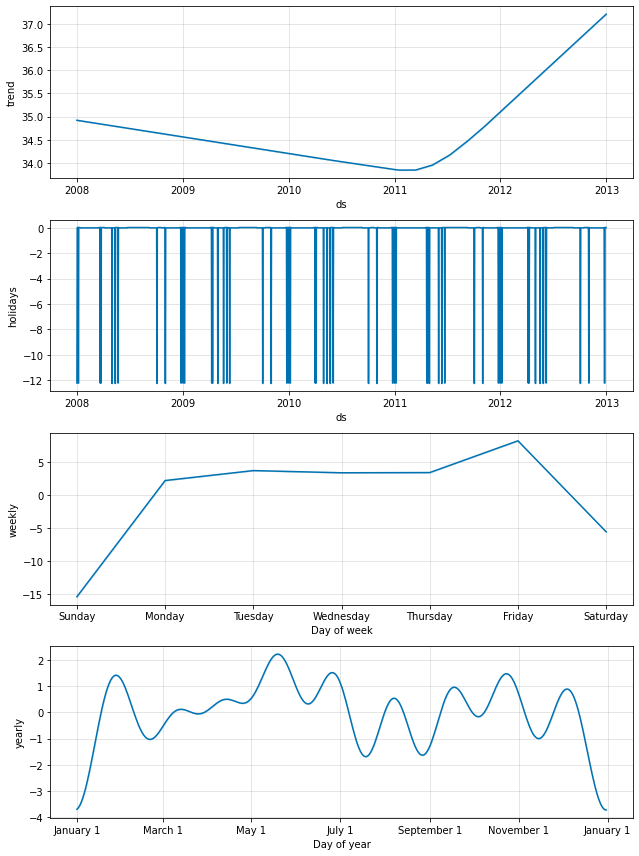

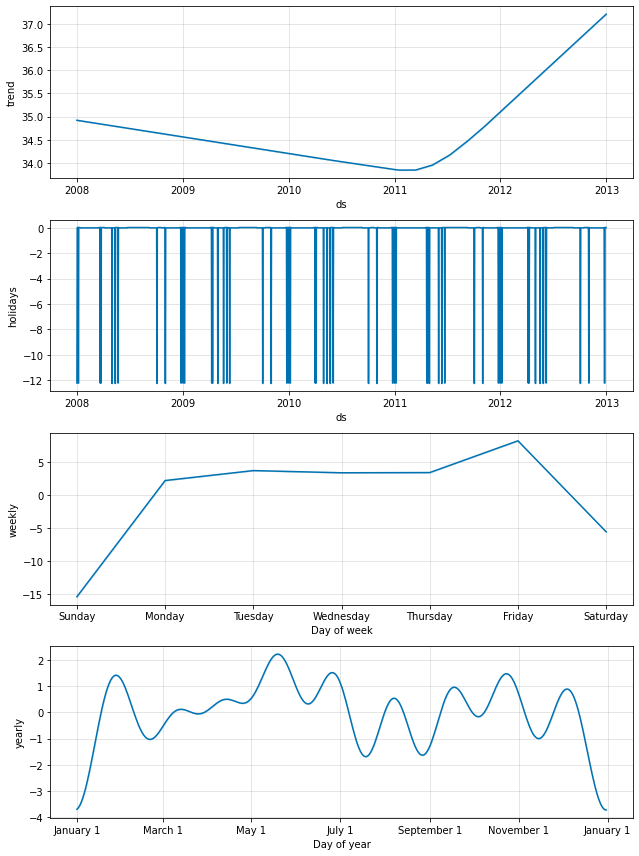

In [ ]:
# Visualize Each Component [Trends,Weekly]
model_D.plot_components(forecast_Dt)


# Admissions 

## Plot




#### Train data Plot

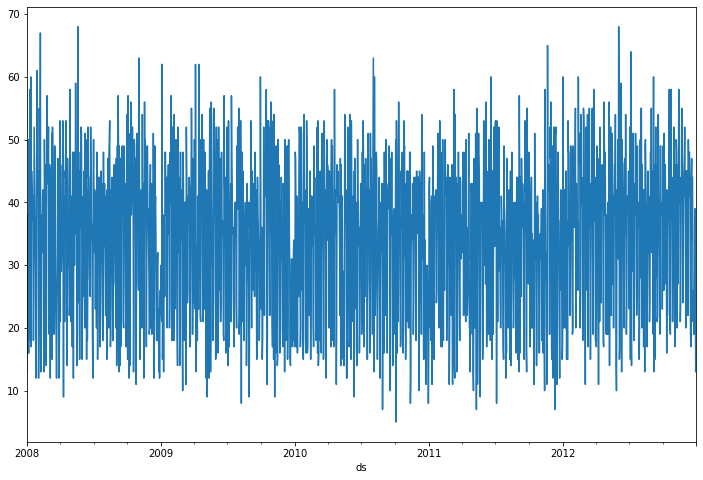

In [ ]:
Train_df_A.set_index('ds').y.plot(figsize=(12,8))

#### Plotting the Whole data

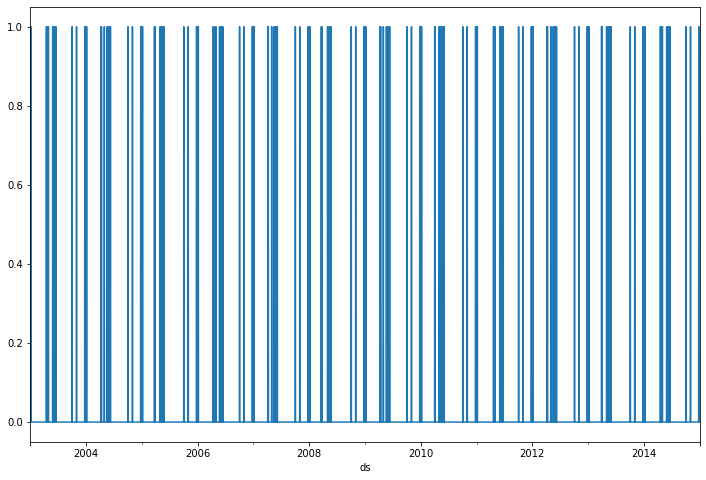

In [ ]:
Full_data_A=Full_data.rename(columns={'Date':'ds', 'Admissions':'y'})


#School holidays Aggregation
# holidays_SH = pd.DataFrame({'ds': Hospital_df["Date"],'holiday': Hospital_df[["S_BW", "S_H","S_RP"]].max(axis=1)})
# holidays_PH = pd.DataFrame({'ds': Hospital_df["Date"],'holiday': Hospital_df[["P_BW", "P_H","P_RP"]].max(axis=1)})
holidays_PH.set_index('ds').holiday.plot(figsize=(12,8))

In [ ]:
holidays_P.set_index('ds').holiday.plot(figsize=(12,8))
# holidays_P

TypeError: ignored

## Stationary Checks and code to make the data stationary

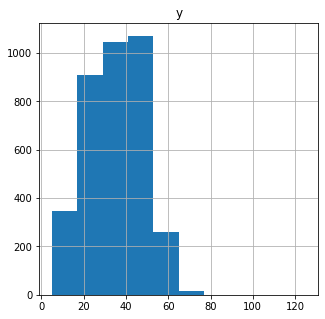

KeyboardInterrupt: ignored

In [ ]:
#To check if the data is stationary
Full_data_A = Full_data_A[['ds','y']]
#Plotting the histogram for check for normal distribution
Full_data_A.hist(figsize=(5,5))
#Adding the horizontal line across the 'y' 
Full_data_A.set_index('ds', inplace=True)
Full_data_A.plot()
plt.axhline(Full_data_A['y'].mean(),c='black')
plt.show()

In [ ]:
# #Making the data Stationary
# Full_data_A['y'] = Full_data_A['y'] - Full_data_A['y'].shift(1)
# Full_data_A.plot()
# plt.axhline(Full_data_A['y'].mean(),c='black')
# plt.show()

## Running Prophet Model for Admissions


In [ ]:
# Passing the holidays dataframe having both school and public holidays as the parameters 
model_A = Prophet(holidays=holidays)
model_A.fit(Train_df_A);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#Holiday names
model_A.train_holiday_names

0    schoolholiday
1    publicholiday
dtype: object

## Forecasting Admissions:

Make a new dataframe containing the dates to be predicted for the future


periods --> number of days into the future

include_history --> True or False to include the training data

freq --> days,hours, months 


In [ ]:
#test
future = model_A.make_future_dataframe(periods=period,include_history = False,freq='D') 
#train
future_t = model_A.make_future_dataframe(periods=0,include_history = True,freq='D') 

To forecast this future data, we need to run it through Prophet's model.

In [ ]:
forecast_A = model_A.predict(future)
forecast_At = model_A.predict(future_t)
print(len(forecast_A.index))

30


Fields needed in the Forecast data :

yhat - Prediction output

yhat_lower and yhat_upper - confidence intervals for the prediction output

In [ ]:
forecast_A[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

## Error Metrics Admissions:


### Actual vs Predicted Plot

In [ ]:
# A vs P Test plot
test = Test_df_A.plot(x='ds',y='y',label='Actual',legend=True)
forecast_A.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(6,4),ax=test)

In [ ]:
# A vs P Train plot
train = Train_df_A.plot(x='ds',y='y',label='Actual',legend=True)
forecast_At.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(6,4),ax=train)

## Error Metrics
Calculation of MAPE,MAE AND RMSE - Test

In [ ]:
print('Mean absolute percentage error: ',mean_absolute_percentage_error(Test_df_A['y'].values,forecast_A['yhat'].values))
print('Mean absolute error: ',mean_absolute_error(Test_df_A['y'].values,forecast_A['yhat'].values))
print('Root Mean Square error: ',root_mean_squared_error(forecast_A['yhat'].values,Test_df_A['y'].values))

Calculation of MAPE, MAE and RMSE - Train

In [ ]:
print('Mean absolute percentage error: ',mean_absolute_percentage_error(Train_df_A['y'].values,forecast_At['yhat'].values))
print('Mean absolute error: ',mean_absolute_error(Train_df_A['y'].values,forecast_At['yhat'].values))
print('Root Mean Square error: ',root_mean_squared_error(forecast_At['yhat'].values,Train_df_A['y'].values))

## Plotting Prophet results and the compoenents

Prophet has a plotting mechanism called ```plot```.  This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

In [ ]:
model_A.plot(forecast_A)

In [ ]:
# Visualize Each Component [Trends,Weekly]
model_A.plot_components(forecast_A)

# Finding Occupancy from predicted Admisisons + Discharges 

Considering the previous occupancy of the last day of training data to find the Occupancy based on the predicted Admissions and Discharges

In [ ]:
#Defining the Occupancy dataframe based on the predicted Admissions and Discharges
O_df = pd.DataFrame(columns = ['ds','Admissions','Discharges','Occupancy'])
O_df['ds'] = forecast_A['ds']
O_df['Admissions'] = forecast_A['yhat']
O_df['Discharges'] = forecast_D['yhat']
#Getting the Previous Occupancy of the last day of Training data
PreviousOccupancy = Train_df.iloc[-1, 3]
#Empty dataframe to append the calculated Occupancy
Occupancy = []

#Loop to calculate Occupancy for the Test data based on the predicted Admissions and Discharges
for i,row in O_df.iterrows():
  PreviousOccupancy = PreviousOccupancy + row['Admissions'] - row['Discharges']
  Occupancy.append(PreviousOccupancy)

O_df['Occupancy'] = Occupancy


In [ ]:
#Defining the Occupancy dataframe based on the train Admissions and Discharges
O_dft = pd.DataFrame(columns = ['ds','Admissions','Discharges','Occupancy'])
O_dft['ds'] = forecast_At['ds']
O_dft['Admissions'] = forecast_At['yhat']
O_dft['Discharges'] = forecast_Dt['yhat']
#Getting the Previous Occupancy of the last day of Training data
PreviousOccupancy = 139
#Empty dataframe to append the calculated Occupancy
Occupancy = []

#Loop to calculate Occupancy for the Test data based on the predicted Admissions and Discharges
for i,row in O_dft.iterrows():
  PreviousOccupancy = PreviousOccupancy + row['Admissions'] - row['Discharges']
  Occupancy.append(PreviousOccupancy)

O_dft['Occupancy'] = Occupancy

In [ ]:
O_df.to_csv(r'forecast_ad_fbprophet.csv')

Actual vs Predicted Occupancy plot

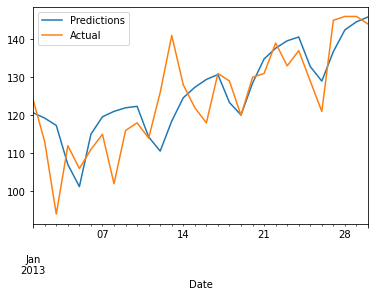

In [ ]:
# A vs P plot
ax = O_df.plot(x='ds',y='Occupancy',label='Predictions',legend=True,figsize=(6,4))
Test_df.plot(x='Date',y='Occupancy',label='Actual',legend=True,ax=ax)

Actual vs Predicted Occupancy plot - Train


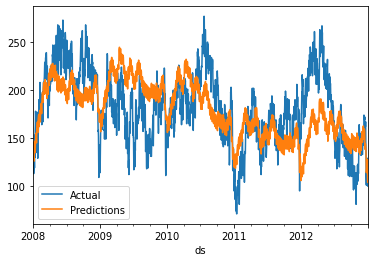

In [ ]:
# A vs P plot

ax = Train_df.plot(x='Date',y='Occupancy',label='Actual',legend=True)
O_dft.plot(x='ds',y='Occupancy',label='Predictions',legend=True,figsize=(6,4),ax=ax)

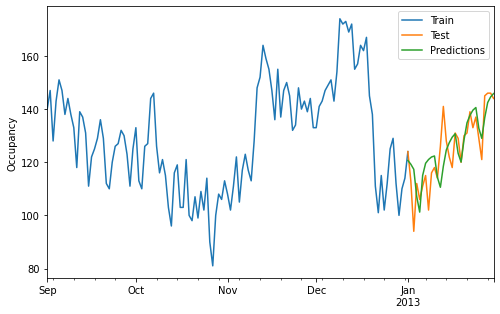

In [ ]:
train_dft = Hospital_df.loc['2012-09-01':'2013-01-01']
test_dft = Hospital_df.loc['2013-01-01':'2013-01-30']
train = train_dft.plot(x='Date',y='Occupancy',label='Train',legend=True)
test = test_dft.plot(x='Date',y='Occupancy',label='Test',legend=True,ax=train)
O_df.plot(x='ds',y='Occupancy',label='Predictions',legend = True,ax=train,figsize=(8,5))
plt.xlabel('')
plt.ylabel('Occupancy')
ax.legend(["Predictions", "Test"])
# plt.title('Best fiProphet Occupancy Model Predictions')

# Error Metrics
MAPE,RMSE And MAE for Calculated Occupancy - Test

In [ ]:
print('Mean absolute percentage error: ',mean_absolute_percentage_error(Test_df['Occupancy'].values,O_df['Occupancy'].values))
print('Mean absolute error: ',mean_absolute_error(Test_df['Occupancy'].values,O_df['Occupancy'].values))
print('Root Mean Square error: ',root_mean_squared_error(O_df['Occupancy'].values,Test_df['Occupancy'].values))

Mean absolute percentage error:  5.32
Mean absolute error:  6.29
Root Mean Square error:  8.72


MAPE,RMSE And MAE for Calculated Occupancy - Train

In [ ]:
print('Mean absolute percentage error: ',mean_absolute_percentage_error(Train_df['Occupancy'].values,O_dft['Occupancy'].values))
print('Mean absolute error: ',mean_absolute_error(Train_df['Occupancy'].values,O_dft['Occupancy'].values))
print('Root Mean Square error: ',root_mean_squared_error(O_dft['Occupancy'].values,Train_df['Occupancy'].values))

Mean absolute percentage error:  15.64
Mean absolute error:  27.15
Root Mean Square error:  33.93


# Testing the for loop - Multiple Training Periods for test data(1-5 years)

In [ ]:
training_time = pd.read_csv('training_time.csv')
# Change the date format
training_time['start'] = pd.to_datetime(training_time['start'], format='%d-%m-%Y')
training_time['end'] = pd.to_datetime(training_time['end'], format='%d-%m-%Y')

Train_df_A = []
Train_df_D = []
mape = []
mae = []
rmse = []

Test_df = Hospital_df.loc['2013-01-01':'2013-01-30']
Test_df= Test_df.rename(columns={'Date':'ds', 'Occupancy':'y'})
period = len(Test_df.index)
O_df = pd.DataFrame(columns = ['ds','Admissions','Discharges','Occupancy'])

for i,row in training_time.iterrows():
  Train_df = Hospital_df.loc[row['start']:row['end']]
  print(len(Train_df.index))

  #prophetmodel_discharge
  Train_df_D=Train_df.rename(columns={'Date':'ds', 'Discharges':'y'})
  Train_df_D = Train_df_D[['ds','y']]
  model_D = Prophet(holidays=holidays)
  model_D.fit(Train_df_D)
  future = model_D.make_future_dataframe(periods=period,include_history = False,freq='D')
  forecast_D = model_D.predict(future)
  #prophetmodel_discharge
  Train_df_A=Train_df.rename(columns={'Date':'ds', 'Admissions':'y'})
  Train_df_A = Train_df_A[['ds','y']]
  model_A = Prophet(holidays=holidays)
  model_A.fit(Train_df_A)
  future = model_A.make_future_dataframe(periods=period,include_history = False,freq='D')
  forecast_A = model_A.predict(future)

  #Defining the Occupancy dataframe based on the predicted Admissions and Discharges
  O_df['Admissions'] = forecast_A['yhat']
  O_df['Discharges'] = forecast_D['yhat']
  O_df['ds'] = forecast_A['ds']
  #Getting the Previous Occupancy of the last day of Training data
  PreviousOccupancy = Train_df.iloc[-1, 3]
  #Empty dataframe to append the calculated Occupancy
  Occupancy = []
 
  #Loop to calculate Occupancy for the Test data based on the predicted Admissions and Discharges
  for i,row in O_df.iterrows():
    PreviousOccupancy = PreviousOccupancy + row['Admissions'] - row['Discharges']
    Occupancy.append(PreviousOccupancy)

  O_df['Occupancy'] = Occupancy
  mape_eachtraining = mean_absolute_percentage_error(Test_df['y'].values,O_df['Occupancy'].values)
  rmse_eachtraining = root_mean_squared_error(O_df['Occupancy'].values,Test_df['y'].values)
  mae_eachtraining = mean_absolute_error(Test_df['y'].values,O_df['Occupancy'].values)
  print('Mean absolute percentage error: ',mape_eachtraining)
  mape.append(mape_eachtraining)
  rmse.append(rmse_eachtraining)
  mae.append(mae_eachtraining)

training_time['MAPE']= mape
training_time['RMSE']= rmse
training_time['MAE']= mae
training_time['Evaluation_time']= period

In [ ]:
training_time

# Testing the for loop - Multiple Training Periods for Train data(1-5 years)

In [ ]:
training_time = pd.read_csv('training_Accuracy_time.csv')
# Change the date format
training_time['start'] = pd.to_datetime(training_time['start'], format='%d-%m-%Y')
training_time['end'] = pd.to_datetime(training_time['end'], format='%d-%m-%Y')

Train_df_A = []
Train_df_D = []
mape = []
mae = []
rmse = []

for i,row in training_time.iterrows():
  O_dft = pd.DataFrame(columns = ['ds','Admissions','Discharges','Occupancy'])
  Train_df = Hospital_df.loc[row['start']:row['end']]
  print(len(Train_df.index))

  #prophetmodel_discharge
  Train_df_D=Train_df.rename(columns={'Date':'ds', 'Discharges':'y'})
  Train_df_D = Train_df_D[['ds','y']]
  model_D = Prophet(holidays=holidays)
  model_D.fit(Train_df_D)
  future = model_D.make_future_dataframe(periods=0,include_history = True)
  forecast_D = model_D.predict(future)
  #prophetmodel_discharge
  Train_df_A=Train_df.rename(columns={'Date':'ds', 'Admissions':'y'})
  Train_df_A = Train_df_A[['ds','y']]
  model_A = Prophet(holidays=holidays)
  model_A.fit(Train_df_A)
  future = model_A.make_future_dataframe(periods=0,include_history = True)
  forecast_A = model_A.predict(future)

  #Defining the Occupancy dataframe based on the predicted Admissions and Discharges
  O_dft['ds'] = forecast_A['ds']
  O_dft['Admissions'] = forecast_A['yhat']
  O_dft['Discharges'] = forecast_D['yhat']

  #Getting the Previous Occupancy of the last day of Training data
  PreviousOccupancy = row['Previous_Occupancy']
  #Empty dataframe to append the calculated Occupancy
  Occupancy = []
 
  #Loop to calculate Occupancy for the Test data based on the predicted Admissions and Discharges
  for i,row in O_dft.iterrows():
    PreviousOccupancy = PreviousOccupancy + row['Admissions'] - row['Discharges']
    Occupancy.append(PreviousOccupancy)

  O_dft['Occupancy'] = Occupancy
  mape_eachtraining = mean_absolute_percentage_error(Train_df['Occupancy'].values,O_dft['Occupancy'].values)
  rmse_eachtraining = root_mean_squared_error(O_dft['Occupancy'].values,Train_df['Occupancy'].values)
  mae_eachtraining = mean_absolute_error(Train_df['Occupancy'].values,O_dft['Occupancy'].values)
  print('Mean absolute percentage error: ',mape_eachtraining)
  mape.append(mape_eachtraining)
  rmse.append(rmse_eachtraining)
  mae.append(mae_eachtraining)

training_time['MAPE']= mape
training_time['RMSE']= rmse
training_time['MAE']= mae

In [ ]:
training_time

# Testing the for loop - Multiple Training and Testing Periods(1-5 years)

In [ ]:
training_time = pd.read_csv('training_time.csv')
evaluation_time = pd.read_csv('evaluation_time.csv')
# Change the date format
training_time['start'] = pd.to_datetime(training_time['start'], format='%d-%m-%Y')
training_time['end'] = pd.to_datetime(training_time['end'], format='%d-%m-%Y')

Train_df_A = []
Train_df_D = []

output = pd.DataFrame()

for i,row in evaluation_time.iterrows():
  
  Test_start = pd.to_datetime('01-01-2013',format='%d-%m-%Y')
  Test_end= Test_start + pd.to_timedelta(row['end'], unit='D')
  print(Test_end)
  Test_df = Hospital_df.loc[Test_start:Test_end]
  Test_df= Test_df.rename(columns={'Date':'ds', 'Occupancy':'y'})
  period = len(Test_df.index)
  O_df = pd.DataFrame(columns = ['ds','Admissions','Discharges','Occupancy'])
  training_time = pd.read_csv('training_time.csv')
  training_time['Evaluation_time']= period
  mape = []
  mae = []
  rmse = []

  for i,row in training_time.iterrows():
    Train_df = Hospital_df.loc[row['start']:row['end']]
    print(len(Train_df.index))

    #prophetmodel_discharge
    Train_df_D=Train_df.rename(columns={'Date':'ds', 'Discharges':'y'})
    Train_df_D = Train_df_D[['ds','y']]
    model_D = Prophet(holidays=holidays)
    model_D.fit(Train_df_D)
    future = model_D.make_future_dataframe(periods=period,include_history = False,freq='D')
    forecast_D = model_D.predict(future)
    #prophetmodel_discharge
    Train_df_A=Train_df.rename(columns={'Date':'ds', 'Admissions':'y'})
    Train_df_A = Train_df_A[['ds','y']]
    model_A = Prophet(holidays=holidays)
    model_A.fit(Train_df_A)
    future = model_A.make_future_dataframe(periods=period,include_history = False,freq='D')
    forecast_A = model_A.predict(future)

    #Defining the Occupancy dataframe based on the predicted Admissions and Discharges
    O_df['Admissions'] = forecast_A['yhat']
    O_df['Discharges'] = forecast_D['yhat']
    O_df['ds'] = forecast_A['ds']
    #Getting the Previous Occupancy of the last day of Training data
    PreviousOccupancy = Train_df.iloc[-1, 3]
    #Empty dataframe to append the calculated Occupancy
    Occupancy = []
  
    #Loop to calculate Occupancy for the Test data based on the predicted Admissions and Discharges
    for i,row in O_df.iterrows():
      PreviousOccupancy = PreviousOccupancy + row['Admissions'] - row['Discharges']
      Occupancy.append(PreviousOccupancy)

    O_df['Occupancy'] = Occupancy
    mape_eachtraining = mean_absolute_percentage_error(Test_df['y'].values,O_df['Occupancy'].values)
    rmse_eachtraining = root_mean_squared_error(O_df['Occupancy'].values,Test_df['y'].values)
    mae_eachtraining = mean_absolute_error(Test_df['y'].values,O_df['Occupancy'].values)
    
    print('Mean absolute percentage error: ',mape_eachtraining)
    mape.append(mape_eachtraining)
    rmse.append(rmse_eachtraining)
    mae.append(mae_eachtraining)

  training_time['MAPE']= mape
  training_time['RMSE']= rmse
  training_time['MAE']= mae
  output = output.append(pd.DataFrame(data = training_time), ignore_index=True)

In [ ]:
print('Mean of 3 months predictions for 5 year Train data duration: ',np.mean(output[output['traindata_duration'] == '5 years']['MAPE']))
output

# 12  Sets Final code - Rolling Evaluation

In [ ]:
# Initialisation model
Train_Start = pd.to_datetime('01-01-2008',format='%d-%m-%Y')
# replace year only
Train_End = pd.to_datetime('31-12-2012',format='%d-%m-%Y')
print(Train_Start)
print(Train_End)

Test_Start = Train_End + pd.to_timedelta(1, unit='D')
Test_End= Test_Start + pd.to_timedelta(29, unit='D')
print(Test_Start)
print(Test_End)

training_time = pd.DataFrame()
mape = []
mae = []
rmse = []
Train_S =[]
Train_E =[]
Test_S =[]
Test_E =[]

for i in range(0,12):
  print('********************************')
  print(i)
  Train_S.append(Train_Start)
  Train_E.append(Train_End)
  Test_S.append(Test_Start)
  Test_E.append(Test_End)

  # Before Training
  Test_df = Hospital_df.loc[Test_Start:Test_End]
  Test_df= Test_df.rename(columns={'Date':'ds', 'Occupancy':'y'})
  Test_df = Test_df[['ds','y']]
  period = len(Test_df.index)
  print(period)
  Train_df = Hospital_df.loc[Train_Start:Train_End]
  print(len(Train_df.index))
  O_df = pd.DataFrame(columns = ['ds','Admissions','Discharges','Occupancy'])
  # Prophetmodel
  #prophetmodel_discharge
  Train_df_D=Train_df.rename(columns={'Date':'ds', 'Discharges':'y'})
  Train_df_D = Train_df_D[['ds','y']]
  model_D = Prophet(holidays=holidays)
  model_D.fit(Train_df_D)
  future = model_D.make_future_dataframe(periods=period,include_history = False,freq='D')
  forecast_D = model_D.predict(future)
  #prophetmodel_discharge
  Train_df_A=Train_df.rename(columns={'Date':'ds', 'Admissions':'y'})
  Train_df_A = Train_df_A[['ds','y']]
  model_A = Prophet(holidays=holidays)
  model_A.fit(Train_df_A)
  future = model_A.make_future_dataframe(periods=period,include_history = False,freq='D')
  forecast_A = model_A.predict(future)

  #Defining the Occupancy dataframe based on the predicted Admissions and Discharges
  O_df['Admissions'] = forecast_A['yhat']
  O_df['Discharges'] = forecast_D['yhat']
  O_df['ds'] = forecast_A['ds']
  #Getting the Previous Occupancy of the last day of Training data
  PreviousOccupancy = Train_df.iloc[-1, 3]
  print(PreviousOccupancy)
  #Empty dataframe to append the calculated Occupancy
  Occupancy = []

  #Loop to calculate Occupancy for the Test data based on the predicted Admissions and Discharges
  for i,row in O_df.iterrows():
    PreviousOccupancy = PreviousOccupancy + row['Admissions'] - row['Discharges']
    Occupancy.append(PreviousOccupancy)

  O_df['Occupancy'] = Occupancy
  mape_eachtraining = mean_absolute_percentage_error(Test_df['y'].values,O_df['Occupancy'].values)
  rmse_eachtraining = root_mean_squared_error(O_df['Occupancy'].values,Test_df['y'].values)
  mae_eachtraining = mean_absolute_error(Test_df['y'].values,O_df['Occupancy'].values)
  print('Mean absolute percentage error: ',mape_eachtraining)
  mape.append(mape_eachtraining)
  rmse.append(rmse_eachtraining)
  mae.append(mae_eachtraining)

  # After Training
  Train_Start = Train_Start + pd.to_timedelta(30, unit='D')
  Train_End = Train_End + pd.to_timedelta(30, unit='D')
  print(Train_Start)
  print(Train_End)

  Test_Start = Test_Start + pd.to_timedelta(30, unit='D')
  Test_End= Test_End + pd.to_timedelta(30, unit='D')
  print(Test_Start)
  print(Test_End)

training_time['Train_Start']= Train_S
training_time['Train_End']= Train_E
training_time['Test_Start']= Test_S
training_time['Test_End']= Test_E
training_time['MAPE']= mape
training_time['RMSE']= rmse
training_time['MAE']= mae

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2008-01-01 00:00:00
2012-12-31 00:00:00
2013-01-01 00:00:00
2013-01-30 00:00:00
********************************
0
30
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


114
Mean absolute percentage error:  5.32
2008-01-31 00:00:00
2013-01-30 00:00:00
2013-01-31 00:00:00
2013-03-01 00:00:00
********************************
1
30
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


144
Mean absolute percentage error:  26.77
2008-03-01 00:00:00
2013-03-01 00:00:00
2013-03-02 00:00:00
2013-03-31 00:00:00
********************************
2
30
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


233
Mean absolute percentage error:  12.86
2008-03-31 00:00:00
2013-03-31 00:00:00
2013-04-01 00:00:00
2013-04-30 00:00:00
********************************
3
30
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


227
Mean absolute percentage error:  15.02
2008-04-30 00:00:00
2013-04-30 00:00:00
2013-05-01 00:00:00
2013-05-30 00:00:00
********************************
4
30
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


194
Mean absolute percentage error:  10.16
2008-05-30 00:00:00
2013-05-30 00:00:00
2013-05-31 00:00:00
2013-06-29 00:00:00
********************************
5
30
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


168
Mean absolute percentage error:  8.39
2008-06-29 00:00:00
2013-06-29 00:00:00
2013-06-30 00:00:00
2013-07-29 00:00:00
********************************
6
30
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


154
Mean absolute percentage error:  11.22
2008-07-29 00:00:00
2013-07-29 00:00:00
2013-07-30 00:00:00
2013-08-28 00:00:00
********************************
7
30
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


185
Mean absolute percentage error:  6.45
2008-08-28 00:00:00
2013-08-28 00:00:00
2013-08-29 00:00:00
2013-09-27 00:00:00
********************************
8
30
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


173
Mean absolute percentage error:  21.64
2008-09-27 00:00:00
2013-09-27 00:00:00
2013-09-28 00:00:00
2013-10-27 00:00:00
********************************
9
30
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


117
Mean absolute percentage error:  31.6
2008-10-27 00:00:00
2013-10-27 00:00:00
2013-10-28 00:00:00
2013-11-26 00:00:00
********************************
10
30
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


217
Mean absolute percentage error:  10.21
2008-11-26 00:00:00
2013-11-26 00:00:00
2013-11-27 00:00:00
2013-12-26 00:00:00
********************************
11
30
1827


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


204
Mean absolute percentage error:  28.83
2008-12-26 00:00:00
2013-12-26 00:00:00
2013-12-27 00:00:00
2014-01-25 00:00:00


In [ ]:
print('Average MAPE on 12 Validation Sets:',np.mean(training_time['MAPE']))
training_time.to_csv('Model4.csv')
#standard deviation of the MAPE value(to be less)
#calculate for 60 and 90 days
#extend for 3-4 years

Average MAPE on 12 Validation Sets: 15.705833333333336


In [ ]:
training_time

# 12 Validation sets testing

In [ ]:
# # Initialisation model
# Train_Start = pd.to_datetime('01-01-2008',format='%d-%m-%Y')
# # replace year only
# Train_End = Train_Start.replace(Train_Start.year + 5)
# print(Train_Start)
# print(Train_End)

# Test_Start = Train_End + pd.to_timedelta(1, unit='D')
# Test_End= Test_Start + pd.to_timedelta(30, unit='D')
# print(Test_Start)
# print(Test_End)

# training_time = pd.DataFrame()
# mape = []
# Train_S =[]
# Train_E =[]
# Test_S =[]
# Test_E =[]

# for i in range(1,12):
#   print('********************************')
#   print(i)
#   Train_S.append(Train_Start)
#   Train_E.append(Train_End)
#   Test_S.append(Test_Start)
#   Test_E.append(Test_End)

#   # Before Training
#   Test_df = Hospital_df.loc[Test_Start:Test_End]
#   Test_df= Test_df.rename(columns={'Date':'ds', 'Occupancy':'y'})
#   Test_df = Test_df[['ds','y']]
#   period = len(Test_df.index)
#   print(period)
#   Train_df = Hospital_df.loc[Train_Start:Train_End]
#   print(len(Train_df.index))
#   O_df = pd.DataFrame(columns = ['ds','Admissions','Discharges','Occupancy'])
#   # Prophetmodel
#   #prophetmodel_discharge
#   Train_df_D=Train_df.rename(columns={'Date':'ds', 'Discharges':'y'})
#   Train_df_D = Train_df_D[['ds','y']]
#   model_D = Prophet(holidays=holidays)
#   model_D.fit(Train_df_D)
#   future = model_D.make_future_dataframe(periods=period,include_history = False,freq='D')
#   forecast_D = model_D.predict(future)
#   #prophetmodel_discharge
#   Train_df_A=Train_df.rename(columns={'Date':'ds', 'Admissions':'y'})
#   Train_df_A = Train_df_A[['ds','y']]
#   model_A = Prophet(holidays=holidays)
#   model_A.fit(Train_df_A)
#   future = model_A.make_future_dataframe(periods=period,include_history = False,freq='D')
#   forecast_A = model_A.predict(future)

#   #Defining the Occupancy dataframe based on the predicted Admissions and Discharges
#   O_df['Admissions'] = forecast_A['yhat']
#   O_df['Discharges'] = forecast_D['yhat']
#   O_df['ds'] = forecast_A['ds']
#   #Getting the Previous Occupancy of the last day of Training data
#   PreviousOccupancy = Train_df.iloc[-1, 3]
#   #Empty dataframe to append the calculated Occupancy
#   Occupancy = []

#   #Loop to calculate Occupancy for the Test data based on the predicted Admissions and Discharges
#   for i,row in O_df.iterrows():
#     PreviousOccupancy = PreviousOccupancy + row['Admissions'] - row['Discharges']
#     Occupancy.append(PreviousOccupancy)

#   O_df['Occupancy'] = Occupancy
#   mape_eachtraining = mean_absolute_percentage_error(Test_df['y'].values,O_df['Occupancy'].values)
#   print('Mean absolute percentage error: ',mape_eachtraining)
#   mape.append(mape_eachtraining)

#   # After Training
#   Train_Start = Train_Start + pd.to_timedelta(31, unit='D')
#   Train_End = Train_Start.replace(Train_Start.year + 5)
#   print(Train_Start)
#   print(Train_End)

#   Test_Start = Test_End + pd.to_timedelta(1, unit='D')
#   Test_End= Test_Start + pd.to_timedelta(31, unit='D')
#   print(Test_Start)
#   print(Test_End)

# training_time['Train_Start']= Train_S
# training_time['Train_End']= Train_E
# training_time['Test_Start']= Test_S
# training_time['Test_End']= Test_E
# training_time['MAPE']= mape

In [ ]:
# print('Average MAPE on 12 Validation Sets:',np.mean(training_time['MAPE']))
# training_time

# 12  Sets Final code - Rolling Evaluation Testing

In [ ]:
training_time = pd.read_csv('Extension.csv')
# Change the date format

Train_df_A = []
Train_df_D = []

output = pd.DataFrame()
mape = []

  
for i,row in training_time.iterrows():
  O_df = pd.DataFrame(columns = ['ds','Admissions','Discharges','Occupancy'])

  Train_Start = row['Train_Start'] 
  Train_End = row['Train_End']
  print(Train_Start)
  print(Train_End)
  Train_df = Hospital_df.loc[row['Train_Start']:row['Train_End']]
  print(len(Train_df.index))
  Test_Start = row['Test_Start'] 
  Test_End = row['Test_End']
  print(Test_Start)
  print(Test_End)
  Test_df = Hospital_df.loc[row['Test_Start']:row['Test_End']]
  period = len(Test_df.index)
  #prophetmodel_discharge
  Train_df_D=Train_df.rename(columns={'Date':'ds', 'Discharges':'y'})
  Train_df_D = Train_df_D[['ds','y']]
  Test_df = Hospital_df.loc[Test_Start:Test_End]
  Test_df= Test_df.rename(columns={'Date':'ds', 'Occupancy':'y'})
  model_D = Prophet(holidays=holidays)
  model_D.fit(Train_df_D)
  future = model_D.make_future_dataframe(periods=period,include_history = False,freq='D')
  forecast_D = model_D.predict(future)
  #prophetmodel_discharge
  Train_df_A=Train_df.rename(columns={'Date':'ds', 'Admissions':'y'})
  Train_df_A = Train_df_A[['ds','y']]
  model_A = Prophet(holidays=holidays)
  model_A.fit(Train_df_A)
  future = model_A.make_future_dataframe(periods=period,include_history = False,freq='D')
  forecast_A = model_A.predict(future)

  #Defining the Occupancy dataframe based on the predicted Admissions and Discharges
  O_df['Admissions'] = forecast_A['yhat']
  O_df['Discharges'] = forecast_D['yhat']
  O_df['ds'] = forecast_A['ds']
  #Getting the Previous Occupancy of the last day of Training data
  PreviousOccupancy = Train_df.iloc[-1, 3]
  print(PreviousOccupancy)
  #Empty dataframe to append the calculated Occupancy
  Occupancy = []

  #Loop to calculate Occupancy for the Test data based on the predicted Admissions and Discharges
  for i,row in O_df.iterrows():
    PreviousOccupancy = PreviousOccupancy + row['Admissions'] - row['Discharges']
    Occupancy.append(PreviousOccupancy)

  O_df['Occupancy'] = Occupancy
  mape_eachtraining = mean_absolute_percentage_error(Test_df['y'].values,O_df['Occupancy'].values)
  
  print('Mean absolute percentage error: ',mape_eachtraining)
  mape.append(mape_eachtraining)

training_time['MAPE']= mape
output = output.append(pd.DataFrame(data = training_time), ignore_index=True)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


01-01-2008
31-12-2012
1827
01-01-2013
31-01-2013


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


114
Mean absolute percentage error:  5.31
01-02-2008
31-01-2013
1857
01-02-2013
28-02-2013


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


154
Mean absolute percentage error:  24.56
01-03-2008
28-02-2013
1884
01-03-2013
31-03-2013


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


227
Mean absolute percentage error:  33.92
01-04-2008
31-03-2013
1914
01-04-2013
30-04-2013


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


227
Mean absolute percentage error:  31.63
01-05-2008
30-04-2013
1943
01-05-2013
31-05-2013


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


194
Mean absolute percentage error:  22.09
01-06-2008
31-05-2013
1973
01-06-2013
30-06-2013


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


151
Mean absolute percentage error:  27.17
01-07-2008
30-06-2013
2002
01-07-2013
31-07-2013


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


165
Mean absolute percentage error:  29.2
01-08-2008
31-07-2013
2032
01-08-2013
31-08-2013


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


190
Mean absolute percentage error:  21.23
01-09-2008
31-08-2013
2062
01-09-2013
30-09-2013


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


154
Mean absolute percentage error:  30.59
01-10-2008
30-09-2013
2091
01-10-2013
31-10-2013


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


131
Mean absolute percentage error:  23.46
01-11-2008
31-10-2013
2121
01-11-2013
30-11-2013


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


209
Mean absolute percentage error:  43.57
01-12-2008
30-11-2013
2150
01-12-2013
31-12-2013


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


190
Mean absolute percentage error:  34.76


In [ ]:
np.mean(training_time['MAPE'])

27.290833333333335